In [130]:
# Read important libraries


import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
from keras import optimizers
from plot_keras_history import plot_history
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [131]:
#reading the dataset here

encoding = 'latin1' 
data = pd.read_csv("ner_dataset.csv",encoding=encoding)

In [132]:
data.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [133]:
data.isna().any()

Sentence #     True
Word           True
POS           False
Tag           False
dtype: bool

In [134]:
data.shape

(1048575, 4)

The dataset has 4 columns - the sentence number, Word, POS, Tag. The sentence number and Word have some null values.   
- The sentence number NaNs is simply the sentence numbers so we can forward fill it.

In [135]:
#Forward filling the sentence number for all NaN values

data["Sentence #"] = data["Sentence #"].fillna(method="ffill")

In [136]:
#Check the nan words in 'Word' column

data[data["Word"].isna()]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
256026,Sentence: 11709,NaN,NN,O
257069,Sentence: 11759,NaN,NN,O
571211,Sentence: 26129,NaN,NN,O
613777,Sentence: 28049,NaN,NN,O
747019,Sentence: 34152,NaN,NN,O
901758,Sentence: 41181,NaN,NN,O
903054,Sentence: 41244,NaN,NN,O
944880,Sentence: 43177,NaN,NN,O
1003438,Sentence: 45887,NaN,NN,O


There are around 10 rows with words as nulls so we keep note of these rows.

In [137]:
words = set(list(data["Word"].values))
words.add("PADword")
n_unique_words = len(words)
print("There are total ",n_unique_words,"unique words in the dataset.")

There are total  35179 unique words in the dataset.


In [138]:
tags = set(list(data["Tag"].values))
n_tags = len(tags)
print("There are total ",n_tags,"tags in the dataset.")

There are total  17 tags in the dataset.


In [139]:
print(tags)

{'B-gpe', 'B-per', 'B-org', 'I-org', 'B-art', 'I-tim', 'I-art', 'B-nat', 'B-eve', 'I-geo', 'I-nat', 'B-geo', 'B-tim', 'I-gpe', 'I-eve', 'I-per', 'O'}


According to the dataset information, the tags represent the following broad classes:  
geo = Geographical Entity  
org = Organization  
per = Person  
gpe = Geopolitical Entity  
tim = Time indicator  
art = Artifact  
eve = Event  
nat = Natural Phenomenon  

Also, there are 2 set of values for each tag. In entity tagging, the BIO representation means the heirarchy of the entities, i.e. :  
    1. B - Beginning of an entity
    2. I - Inside an entity
    3. O - Other(not related to any entity)  

For example, the sentence: "IPhone 15 was launched by Apple Inc in USA." The entity breakdown of this sentence is:  
    - Iphone - B-art  
    - 15 - I-art  
    - was - O  
    - launched - O  
    - by - O  
    - Apple - B-org  
    - Inc - I-org  
    - in - O  
    - USA - B-geo  

In [140]:
tag_freq_plot = data["Tag"].value_counts().reset_index()

fig = px.bar(tag_freq_plot, x="Tag", y="count", title="Frequency chart of each entity")
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()

As expected the "O" tag is the highest, while the frequency of B-art, B-eve, I-art, I-eve, B-nat, I-gpe and I-nat is is much scarce compared to other like B-geo, B-tim, etc.

In [141]:
uni_sentence = set(list(data["Sentence #"].values))
n_sen = len(uni_sentence)
print("There are total ",n_sen,"sentences in the dataset.")

There are total  47959 sentences in the dataset.


In [142]:
word_counts = data.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})

Majority of the sentences lie between the 11 - 30 words per sentence.

In [143]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 104 words.


In [144]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is Sentence: 22480.


In [145]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Create a histogram trace
trace = go.Histogram(x=word_counts["Word count"], xbins=dict(start=min(word_counts["Word count"]), end=max(word_counts["Word count"]), size=5), opacity=0.7)

# Create a layout
layout = go.Layout(title="Histogram Plot of the length of sentences")

# Create a figure and add the trace
fig = go.Figure(data=[trace], layout=layout)

# Display the plot (offline mode)
pyo.iplot(fig)

In [146]:
longest_sentence = data[data["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


In [147]:
all_words = list(set(data["Word"].values))
all_tags = list(set(data["Tag"].values))

print("Number of unique words: {}".format(data["Word"].nunique()))
print("Number of unique tags : {}".format(data["Tag"].nunique()))

Number of unique words: 35177
Number of unique tags : 17


The first step is to build a dictionary (word_to_index) that assigns a unique integer value to every word from the corpus.   
We also construct a reversed dictionary that maps indices to words (index_to_word).

In [148]:
word_to_index = {word: idx + 2 for idx, word in enumerate(all_words)}
word_to_index["--UNKNOWN_WORD--"]=0
word_to_index["--PADDING--"]=1


index_to_word = {idx: word for word, idx in word_to_index.items()}

In [149]:
#An example of the indexed string example
for k,v in sorted(word_to_index.items(), key=operator.itemgetter(1))[:20]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
distributions 2
Kiliclar 3
capsized 4
netting 5
Nazianzen 6
solutions 7
Russia-backed 8
Cheap 9
Cayes 10
13.5 11
Zagreb 12
Rizvan 13
Klebnikov 14
Timor-Leste 15
Lausanne-based 16
EPRDF 17
Jilin 18
167-seat 19


In [150]:
#Cross-checking the performance of the current indexing and reverse indexing
test_word = "India"

test_word_idx = word_to_index[test_word]
test_word_lookup = index_to_word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word India is 3787.
The word with index 3787 is India.


In [151]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

This custom function  will iterate over each sentence, and form a tuple consisting of each token, the part of speech the token represents, and its tag. This function is applied to the entire dataset.

In [152]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data.groupby("Sentence #").apply(to_tuples).tolist()

print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


We use this transformed dataset to extract the features (X) and labels (y) for the model. We can see what the first entries in X and y look like, after the two have been populated with words and tags. We can discard the part of speech data, as it is not needed for this specific implementation.

In [153]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [154]:
X = [[word_to_index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [4111, 1590, 18483, 24191, 24201, 28266, 13700, 14033, 31943, 14608, 11432, 15636, 31794, 21981, 27466, 14608, 21456, 1590, 23858, 11796, 27718, 11007, 13186, 34955]
y[0]: [17, 17, 17, 17, 17, 17, 12, 17, 17, 17, 17, 17, 12, 17, 17, 17, 17, 17, 1, 17, 17, 17, 17, 17]


Padding the sentences in case they are smaller than the Maximum sentence length of 104

In [155]:
X = [sentence + [word_to_index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [4111, 1590, 18483, 24191, 24201, 28266, 13700, 14033, 31943, 14608, 11432, 15636, 31794, 21981, 27466, 14608, 21456, 1590, 23858, 11796, 27718, 11007, 13186, 34955, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [17, 17, 17, 17, 17, 17, 12, 17, 17, 17, 17, 17, 12, 17, 17, 17, 17, 17, 1, 17, 17, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The final output variable must be one-hot encoded to ensure that it is read-able by the Bi-LSTM

In [156]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [4111, 1590, 18483, 24191, 24201, 28266, 13700, 14033, 31943, 14608, 11432, 15636, 31794, 21981, 27466, 14608, 21456, 1590, 23858, 11796, 27718, 11007, 13186, 34955, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Splitting the dataset into train and test sets, shuffling is not done as we need to preserve the serial construct of the sentences.

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 40765
Number of sentences in the test dataset : 7194


In [158]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [159]:
# Define the parameters to be used for the Deep Learning model
WORD_COUNT = len(index_to_word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5


In [160]:

# Input layer
input_layer = layers.Input(shape=(MAX_SENTENCE,))

# Embedding layer
embedding_layer = layers.Embedding(input_dim=WORD_COUNT, output_dim=DENSE_EMBEDDING, input_length=MAX_SENTENCE, embeddings_initializer="uniform")(input_layer)

# Bidirectional LSTM layer
lstm_layer = layers.Bidirectional(layers.LSTM(units=LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(embedding_layer)

# TimeDistributed Dense layer
time_distributed_layer = layers.TimeDistributed(layers.Dense(units=DENSE_UNITS, activation="relu"))(lstm_layer)

# Output layer with 18 classes and softmax activation
output_layer = layers.TimeDistributed(layers.Dense(units=18, activation="softmax"))(time_distributed_layer)

# Create the NER model
ner_model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
loss = "categorical_crossentropy"  
optimizer = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]  

ner_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Display model summary
ner_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 104)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 104, 50)           1759000   
                                                                 
 bidirectional_9 (Bidirecti  (None, 104, 100)          40400     
 onal)                                                           
                                                                 
 time_distributed_10 (TimeD  (None, 104, 100)          10100     
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 104, 18)           1818      
 istributed)                                                     
                                                           

In [161]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)

Epoch 1/5
144/144 - 70s - loss: 0.5288 - accuracy: 0.9126 - val_loss: 0.1609 - val_accuracy: 0.9673 - 70s/epoch - 487ms/step
Epoch 2/5
144/144 - 90s - loss: 0.1255 - accuracy: 0.9689 - val_loss: 0.0866 - val_accuracy: 0.9733 - 90s/epoch - 624ms/step
Epoch 3/5
144/144 - 83s - loss: 0.0726 - accuracy: 0.9779 - val_loss: 0.0635 - val_accuracy: 0.9821 - 83s/epoch - 576ms/step
Epoch 4/5
144/144 - 100s - loss: 0.0481 - accuracy: 0.9866 - val_loss: 0.0442 - val_accuracy: 0.9885 - 100s/epoch - 691ms/step
Epoch 5/5
144/144 - 104s - loss: 0.0328 - accuracy: 0.9912 - val_loss: 0.0359 - val_accuracy: 0.9905 - 104s/epoch - 721ms/step


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

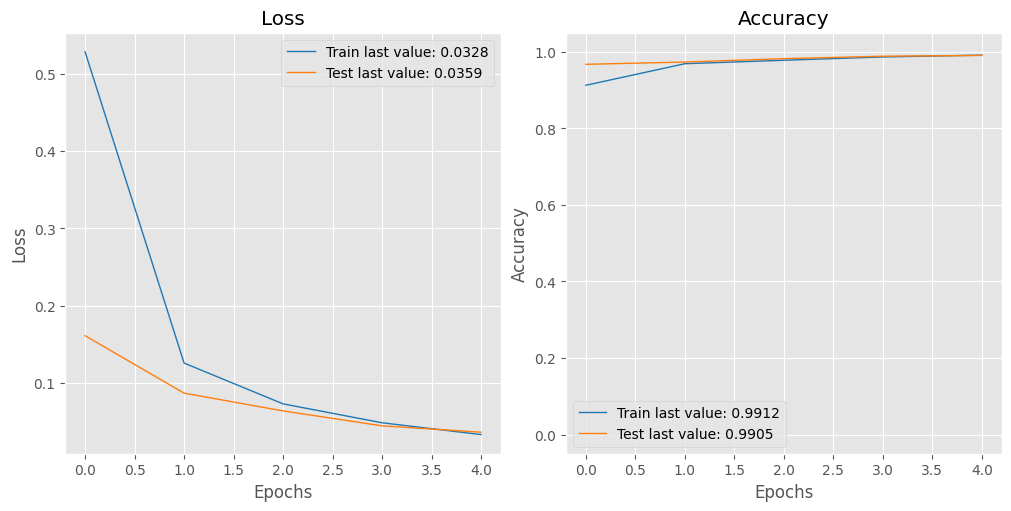

In [162]:
plot_history(history.history)

In [163]:
y_pred = ner_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=2)


225/225 [==============================] - 6s 23ms/step


In [167]:

y_test = np.argmax(y_test, axis=2)
accuracy = (y_pred == y_test).mean()
print("Accuracy on unseen test dataset is : {:.4f}".format(accuracy))

Accuracy on unseen test dataset is : 0.9904


This is SPLENDID!

In [172]:
def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 3)
tag_conf_matrix(matrix, 16)

Tag name: B-org
[[744160    912]
 [  1239   1865]]
Tag accuracy: 0.997 

Tag name: I-per
[[744880    514]
 [   548   2234]]
Tag accuracy: 0.999 



Let's check the accuracy on totally some totally unseen text data as below.

In [185]:
sentence = "President Trump and the former President Obama have differents idea of the American politics since January,2016"

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"  ", sentence).split()

padded_sentence = sentence + [word_to_index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word_to_index.get(w, 0) for w in padded_sentence]

pred = ner_model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) +" \n"



1/1 [==============================] - 0s 22ms/step


In [186]:
print(retval)

President      : B-per 
Trump          : I-per 
and            : O     
the            : O     
former         : O     
President      : B-per 
Obama          : I-per 
have           : O     
differents     : O     
idea           : O     
of             : O     
the            : O     
American       : B-gpe 
politics       : O     
since          : O     
January        : B-tim 
2016           : I-tim 



It looks great :)